## Trajectory Simulation

In [1446]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook

In [1447]:

def create_trajectory(var = 0.01, k = 100, x_0 = np.zeros(4)):
    """
    creates the target trajectory of the constant velocity model
    
    var : process variance
    
    k : length of simulated trajectory
    
    x_0 : initialization of target trajectory | vector of size 4.
    
    returns a trajectory of length k + 1
    """
    Z = np.zeros((2,2))
    Q = np.array([[1/4, 1/2], [1/2, 1]])
    Q = np.vstack([np.block([Q,Z]), np.block([Z,Q])]) * var
    F = np.array([[1, 1], [0, 1]])
    F = np.vstack([np.block([F, Z]), np.block([Z, F])])

    trajectory = [x_0]
    x_i = x_0
    for i in range(k):
        x_i = np.random.multivariate_normal(mean = F.dot(x_i), cov = Q)
        trajectory.append(x_i)
    
    return np.array(trajectory)

In [1448]:
def create_observations(trajectory, var = 0.01):
    """
    creates simulated observations from a trajectory
    
    trajectory: np.array of size n x 4 where n is the length of the trajectory
    
    var = observation noise variance
    
    returns an observation trajectory of length len(trajectory)
    """
    H = np.array([[1,0,0,0], [0,0,1,0]])
    R = np.eye(2) * var
    
    observations = []
    for x_i in trajectory:
        obs_i = np.random.multivariate_normal(mean = H.dot(x_i), cov = R)
        observations.append(obs_i)
    
    return np.array(observations)

## Kalman Filter

In [1449]:
def kalman_filter(observations, noise_var = 10, process_var = 0.01):
    """
    computes kalman filtered trajectory from observations
    
    observations : np.array of size n x 2 where n is the length of the trajectory
    
    noise_var : observation noise variance
    
    process_var : process variance
    
    returns a filtered trajectory of length len(observations)
    """
    Z = np.zeros((2,2))
    Q = np.array([[1/4, 1/2], [1/2, 1]])
    Q = np.vstack([np.block([Q,Z]), np.block([Z,Q])]) * process_var
    F = np.array([[1, 1], [0, 1]])
    F = np.vstack([np.block([F, Z]), np.block([Z, F])])
    H = np.array([[1,0,0,0], [0,0,1,0]])
    R = np.eye(2) * noise_var
    
    P = np.eye(4)
    m = np.ones(4)
    K = np.ones((4, 2))
    
    predictions = []
    for z_i in observations[1:]:
        # PREDICTION
        P = F.dot(P.dot(F.T)) + Q
        m = F.dot(m)
        
        # KALMAN GAIN
        K  = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T) + R))
        
        # UPDATE
        P = (np.eye(4) - K.dot(H)).dot(P)
        m = m + K.dot(z_i - H.dot(m))        
        
        predictions.append(F.dot(m))
        
    return np.array(predictions)

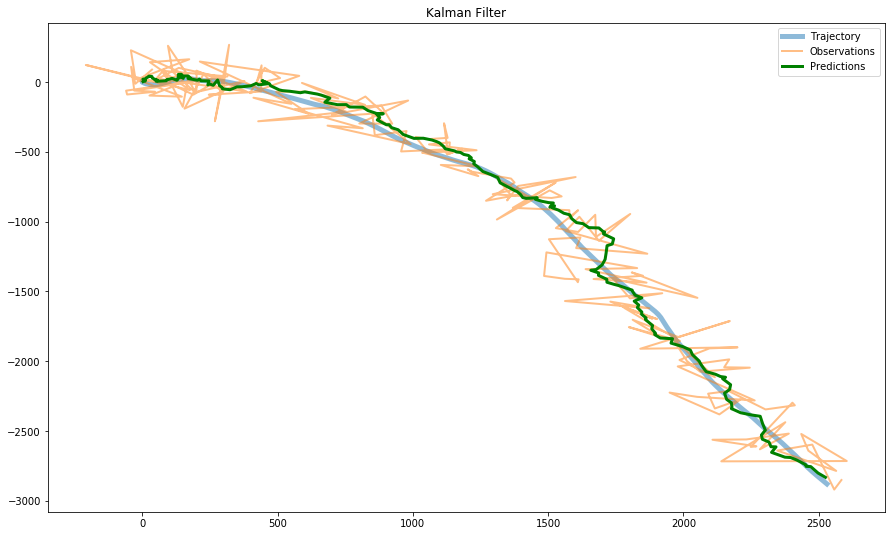

In [1453]:
PROCESS_VAR = 1
OBS_VAR = 10000
LENGTH = 200

trajectory = create_trajectory(var = PROCESS_VAR, k = LENGTH)
observations = create_observations(trajectory, var = OBS_VAR)
predictions = kalman_filter(observations, OBS_VAR, PROCESS_VAR)

x1 = trajectory[:, 0]
x2 = trajectory[:, 2]
z1 = observations[:, 0]
z2 = observations[:, 1]
kalman_x1 = predictions[:, 0]
kalman_x2 = predictions[:, 2]

plt.plot(x1, x2, label = "Trajectory", alpha = 0.5 ,linewidth = 5)
plt.plot(z1, z2, label = 'Observations', alpha = 0.5, linewidth = 2)
plt.plot(kalman_x1, kalman_x2, label = 'Predictions', linewidth = 3, color = 'green')
plt.legend()
plt.title('Kalman Filter')

fig = plt.gcf()
fig.set_size_inches((15,9))

## Gaussian Sum Filter

In [1455]:
def gauss_sum_filter(weights, observations, noise_var = 10, process_var = 0.01):
    """
    computes gaussian-sum filtered trajectory from observations
    
    weights : np.array such that weights.sum() = 1
    
    observations : np.array of shape (n, 2) where n is the length of the trajectory
    
    noise_var : observation noise variance
    
    process_var : process variance
    
    returns a filtered trajectory of length len(observations)
    """
    n_gaussians = len(weights)
    Z = np.zeros((2,2))
    Q = np.array([[1/4, 1/2], [1/2, 1]])
    Q = np.vstack([np.block([Q,Z]), np.block([Z,Q])]) * process_var
    F = np.array([[1, 1], [0, 1]])
    F = np.vstack([np.block([F, Z]), np.block([Z, F])])
    H = np.array([[1,0,0,0], [0,0,1,0]])
    R = np.eye(2) * noise_var
    
    P = np.array([np.eye(4)] * n_gaussians)
    m = np.array([np.ones(4)] * n_gaussians)
    K = np.array([np.zeros((4,2))] * n_gaussians)
    
    predictions = []
    for z_i in observations[0:]:
        q = []
        for i in range(n_gaussians):
            # PREDICTION
            P[i] = F.dot(P[i].dot(F.T)) + Q
            m[i]= F.dot(m[i])
            
            q.append(multivariate_normal(mean = H.dot(m[i]), cov = R + H.dot(P[i].dot(H.T))))

            # KALMAN GAIN
            K[i]  = P[i].dot(H.T).dot(np.linalg.inv(H.dot(P[i]).dot(H.T) + R))

            # UPDATE
            P[i] = (np.eye(4) - K[i].dot(H)).dot(P[i])
            m[i] = m[i] + K[i].dot(z_i - H.dot(m[i]))
            
        # update weights
        evals = np.zeros(n_gaussians)
        for i in range(n_gaussians):
            evals[i] = q[i].pdf(z_i)
            
        weights = evals * weights
        weights = weights / weights.sum()
        
        # compute weighted average of means
        pred = (m.T * weights).sum(axis = 1)
        predictions.append(pred)
 
    return np.array(predictions)

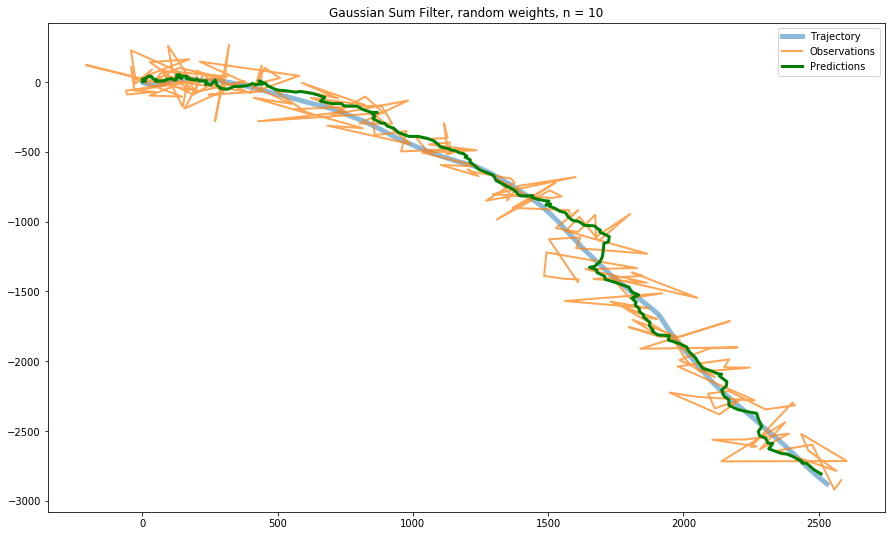

In [1456]:
n = 10
weights = np.random.rand(n)
weights = weights /weights.sum()
predictions = gauss_sum_filter(weights, observations, OBS_VAR, PROCESS_VAR)

gaussum_x1 = predictions[:, 0]
gaussum_x2 = predictions[:, 2]

plt.plot(x1, x2, label = "Trajectory", alpha = 0.5 ,linewidth = 5)
plt.plot(z1, z2, label = 'Observations', alpha = 0.7, linewidth = 2)
plt.plot(gaussum_x1, gaussum_x2, label = 'Predictions', linewidth = 3, color = 'green')
plt.legend()
plt.title('Gaussian Sum Filter, random weights, n = ' + str(n))

fig = plt.gcf()
fig.set_size_inches((15,9))

## Comparison : Kalman vs Gaussian Sum

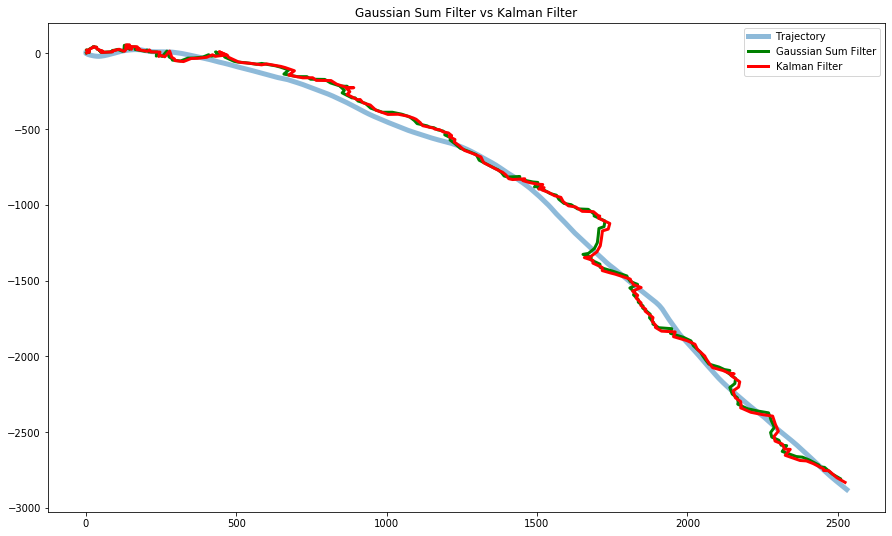

In [1457]:
plt.plot(x1, x2, label = "Trajectory", alpha = 0.5 ,linewidth = 5)
plt.plot(gaussum_x1, gaussum_x2, label = 'Gaussian Sum Filter', linewidth = 3, color = 'green')
plt.plot(kalman_x1, kalman_x2, label = 'Kalman Filter', linewidth = 3, color = 'red')
plt.legend()
plt.title('Gaussian Sum Filter vs Kalman Filter')

fig = plt.gcf()
fig.set_size_inches((15,9))

## Multi-target simulator


In [1458]:
def simulate_multi_trajectory(var = 0.01, start_targets = 2, max_targets = 200, k = 100, survival_prob = 0.99, birth_rate = 0.2, birth_variance = 100):
    """
    simulates multi target trajectories of the constant velocity model
    
    var : process variance 
    
    start_targets : number of targets at the start of the simulation
    
    max_targets : maximum number of targets
    
    k : length of simulated trajectories
    
    survival_prob : probability of a target surviving the next time step
    
    birth_rate : rate of the Poisson distribution modelling the number of births at a given time step.
    
    birth_variance: variance of birth location and momentum.
    """
    
    # Instantiate matrix of trajectories
    trajectories = np.empty((max_targets, k, 4))
    trajectories[:] = np.nan
    
    # Dynamical model matrices
    Z = np.zeros((2,2))
    Q = np.array([[1/4, 1/2], [1/2, 1]])
    Q = np.vstack([np.block([Q,Z]), np.block([Z,Q])]) * var
    F = np.array([[1, 1], [0, 1]])
    F = np.vstack([np.block([F, Z]), np.block([Z, F])])
    
    n_targets = start_targets
    target_spots = [i for i in range(max_targets)]
    alive_targets = []
    dead_targets = []
    
    for i in range(n_targets):
        alive_targets.append(target_spots.pop(0))
        trajectories[i, 0] = np.zeros(4)
    
    for time_step in range(1,k):
        for target in alive_targets:
            a = np.random.binomial(1, survival_prob)
            # simulate deaths
            if a == 0:
                alive_targets.remove(target)
                dead_targets.append(target)
            # simulate movement
            if a == 1:
                trajectories[target, time_step] = np.random.multivariate_normal(mean = F.dot(trajectories[target, time_step-1]), cov = Q)
        # simulate births
        if target_spots:
            n_new_targets = min(np.random.poisson(birth_rate), len(target_spots))
            
            # assign target numbers from remaining target spots
            for i in range(n_new_targets): 
                alive_targets.append(target_spots.pop(0))
                trajectories[alive_targets[-1], time_step] = np.random.multivariate_normal(mean = np.zeros(4), cov = np.eye(4)*birth_variance)
    return trajectories
        
    
    
    

In [1459]:
def simulate_multi_observations(trajectories, var = 0.01, prob_detection = 0.98):
    """
    simulates multi target observations from a set of trajectories
    
    trajectories : set of trajectories of shape (n, k, 4) where n is the number of targets,
    k is the length of the trajectories
    
    var : observation noise variance 
    
    start_targets : number of targets at the start of the simulation
    
    max_targets : maximum number of targets
    
    k : length of simulated trajectories
    
    survival_prob : probability of a target surviving the next time step
    
    birth_rate : rate of the Poisson distribution modelling the number of births at a given time step.
    
    birth_variance: variance of birth location.
    """
    R = np.eye(2) * var
    n, k , _ = trajectories.shape
    observations = np.empty((n, k, 2))
    observations[:] = np.nan
    
    for i,trajectory in enumerate(trajectories):
        for j,state in enumerate(trajectory):
            if not np.isnan(state).any(): # if the object is born
                if np.random.rand() <= prob_detection: # if the object has been detected
                    # Then add observation
                    observations[i, j] = np.random.multivariate_normal(mean = state.T[[0, 2]], cov = R)
    
    return observations

## Full GM PHD filter

In [1460]:
def gm_phd_filter(observations, noise_var = 10, process_var = 10,
                  birth_rate = 0.2, birth_variance = 100, birth_weight = 0.5,
                  prob_survival = 0.99, prob_detection = 0.98,
                  max_components = 100, merging_threshold = 1e-2, truncation_threshold = 1e-6
                 ):
    """
    Applies GM PHD filter with no false alarm. 
    
    observations : np.array of shape (n, K, 2) where n is the number of targets, k is the length of the observations
    
    noise_var : observation noise variance
    
    process_var : process variance

    birth_rate : expected number of births at each time step
    
    birth_variance: variance of birth location and momentum
    
    prob_survival : probability of survival of a target at each time step
    
    prob_detection : probability of detection of a target at each time step
    
    max_components : maximum number of components we keep at each time step
    
    merging_threshold, truncation_threshold: pruning parameters
    
    
    returns a filtered trajectory of length K.
    
    
    """

    _, K, _ = observations.shape
    
    start_targets = (1 - np.isnan(observations[:, 0])).sum() / 2 # J_0
    start_targets = int(start_targets)
    n_components = start_targets  # number of "surviving components" at time 0
    
    # Dynamic model parameters
    Z = np.zeros((2,2))
    Q = np.array([[1/4, 1/2], [1/2, 1]])
    Q = np.vstack([np.block([Q,Z]), np.block([Z,Q])]) * process_var
    F = np.array([[1, 1], [0, 1]])
    F = np.vstack([np.block([F, Z]), np.block([Z, F])])

    # Observation model parameters
    H = np.array([[1,0,0,0], [0,0,1,0]])
    R = np.eye(2) * noise_var
    
    # Initialise m, P, weights arbitrarily
    weights = np.ones(n_components) / n_components
    m = np.zeros(4)
    ms = np.zeros((n_components, 4)) # Store one vector for each component 
    P = np.eye(4) * birth_variance
    Ps = np.ones((n_components, 4, 4)) # Store one matrix for each component
    
    predictions = []
    weight_list = []
    for k in tqdm_notebook(range(K)):
        # determine number of targets at time-step k
        n_births = np.random.poisson(birth_rate)
        n_components = n_components + n_births
        
        #####  PREDICTION  ######################################
        
        # Initialise birth components
        ms_k = np.ones((n_components, 4))
        Ps_k = np.ones((n_components, 4, 4)) * 100
        weights_k = np.ones(n_components)
        
        for i in range(n_births):
            weights_k[i] = birth_weight
            gaussian_mixture = multivariate_normal(mean = m , cov = P)
            ms_k[i] = gaussian_mixture.rvs()
            Ps_k[i] = P.copy()
        
        # Prediction for surviving components
        for i in range(n_births, n_components):
            weights_k[i] = prob_survival * weights[i - n_births]
            ms_k[i] = F.dot(ms[i - n_births])
            Ps_k[i] = F.dot(Ps[i - n_births].dot(F.T)) + Q
            
        ###### UPDATE  ##########################################
            
        # Update for undetected targets
        
        for i in range(n_components):
            weights_k[i] = (1 - prob_detection)*weights_k[i]
        
        # Compute parameters for Kalman filter
        
        S = np.ones((n_components, 2, 2))
        K = np.ones((n_components, 4, 2))
        zs = np.ones((n_components, 2))
        for i in range(n_components):
            zs[i] = H.dot(ms_k[i])                             # predicted observation
            S[i] = H.dot(Ps_k[i]).dot(H.T) + R                 # predicted observation covariance
            K[i] = Ps_k[i].dot(H.T).dot(np.linalg.inv(S[i]))   # Kalman gain
            Ps_k[i] = (np.eye(4) - K[i].dot(H)).dot(Ps_k[i])   # We update P now for efficiency
            
            
        n_obs = (1 - np.isnan(observations[:, k])).sum() / 2
        n_obs = int(n_obs)
        
        
        # Compute and store the gaussian mixtures
        
        ms_gm = np.ones((n_obs * n_components, 4))
        Ps_gm = np.ones((n_obs * n_components, 4, 4))
        weights_gm = np.ones((n_obs * n_components))
        obs_indices = np.where(1 - np.isnan(observations[:, k, 0]))[0]
        for j in range(n_obs):  # for each measurement
            # for each measurement we create n_components components
            for i in range(n_components):  # for each component
                z = observations[obs_indices[j], k]  # current observation
                
                ms_gm[i + j*n_components] = ms_k[i] + K[i].dot(z - zs[i])   # Kalman updated mean
                Ps_gm[i + j*n_components] = Ps_k[i]                         # Kalman updated covariance (already updated)
            
            
                gaussian_component = multivariate_normal(mean = zs[i] , cov = S[i])   # Instantiate GM to evaluate pdf
                weights_gm[i + j*n_components] = prob_detection * weights_k[i] * (gaussian_component.pdf(z))
                ## If the observation variance is too high, the algorithm is unstable because
                # gaussian_component.pdf(z) will return 0
            

        for j in range(n_obs):
            det = 0
            clutter = 1e-15 # for numerical stability
            for i in range(n_components):
                det += weights_gm[i + j*n_components]
            for i in range(n_components):                    
                weights_gm[i + j*n_components] = weights_gm[i + j*n_components] / (clutter + det)

        ###### PRUNING  ##########################################
        # directly implemented from Vo and Ma
    
        indices = np.where(weights_gm > truncation_threshold)[0].tolist()
        l = 0
        weights_pruned = []
        ms_pruned = []
        Ps_pruned = []
        while(len(indices) > 0 and len(weights)> 0):
            l = l+1
            j = np.argmax(weights)
            merging_values = [(ms_gm[i] - ms_gm[j]).T.dot(np.linalg.inv(Ps_gm[i])).dot(ms_gm[i] - ms_gm[j]) for i in indices]
            L = np.where(np.array(merging_values) <= merging_threshold)[0]
            L = np.array(indices)[L]
            if L.size > 0:
                weights_pruned.append(weights_gm[L].sum())
                ms_pruned.append((ms_gm[L].T * weights_gm[L]).sum(axis = 1) / weights_pruned[-1])
                P_temp = np.zeros((4, 4))
                for i in L:
                    m_temp = ms_pruned[-1] - ms_gm[i]
                    P_temp += weights_gm[i]*(Ps_gm[i] + m_temp.dot(m_temp.T))
                Ps_pruned.append(P_temp / weights_pruned[-1])
                for i in L:
                    indices.remove(i)
            else:
                for i in indices:
                    weights_pruned.append(weights_gm[i])
                    ms_pruned.append(ms_gm[i])
                    Ps_pruned.append(Ps_gm[i])
                    indices.remove(i)
                    
                    
        top_components = np.argsort(weights_pruned)[::-1][:min(max_components, len(weights_pruned))]
        ms = np.array(ms_pruned)[top_components]
        weights = np.array(weights_pruned)[top_components]
        Ps = np.array(Ps_pruned)[top_components]
        n_components = len(top_components)
        
        predictions.append(ms)
        weight_list.append(weights)
        
    # some processing for predictions to be in the right shape for plotting
    if True:
        max_len = 0
        for i in range(len(predictions)):
            if len(predictions[i]) > max_len:
                max_len = len(predictions[i])

        prediction = np.empty((max_len, len(predictions), 4))
        prediction[:] = np.nan
        for i in range(len(predictions)):
            for j in range(len(predictions[i])):
                prediction[j, i] = predictions[i][j]
    return prediction, weight_list
        
        
        
    

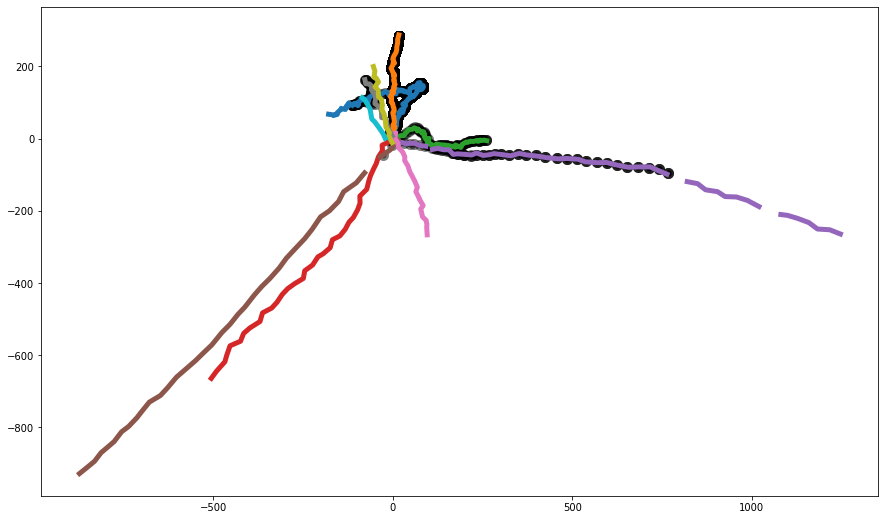

In [1464]:
PROCESS_VAR = 1
OBS_VAR = 10
LENGTH = 100
BIRTH_RATE = 0.1
SURVIVAL_PROB = 0.99
DETECTION_PROB = 0.98
START_TARGETS = 2
MAX_TARGETS = 10



trajectories = simulate_multi_trajectory(var = PROCESS_VAR,start_targets = START_TARGETS,
                                         max_targets = MAX_TARGETS, k = LENGTH,
                                         survival_prob = SURVIVAL_PROB, birth_rate = BIRTH_RATE)


observations = simulate_multi_observations(trajectories, var = OBS_VAR, prob_detection = DETECTION_PROB)

for trajectory in observations:
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha = 1, linewidth = 5)
    
    
predictions, weights = gm_phd_filter(observations, noise_var = OBS_VAR, process_var = PROCESS_VAR,
                  birth_rate = BIRTH_RATE, birth_variance = 10, birth_weight = 1,
                  prob_survival = SURVIVAL_PROB, prob_detection = DETECTION_PROB,
                  max_components = 100, merging_threshold = 1e-2, truncation_threshold = 1e-6
                 )

for i, trajectory in enumerate(predictions):
    plt.scatter(trajectory[:, 0], trajectory[:, 2], alpha = 0.5, linewidth = 5, color = 'black')
    
fig = plt.gcf()
fig.set_size_inches(15,9)

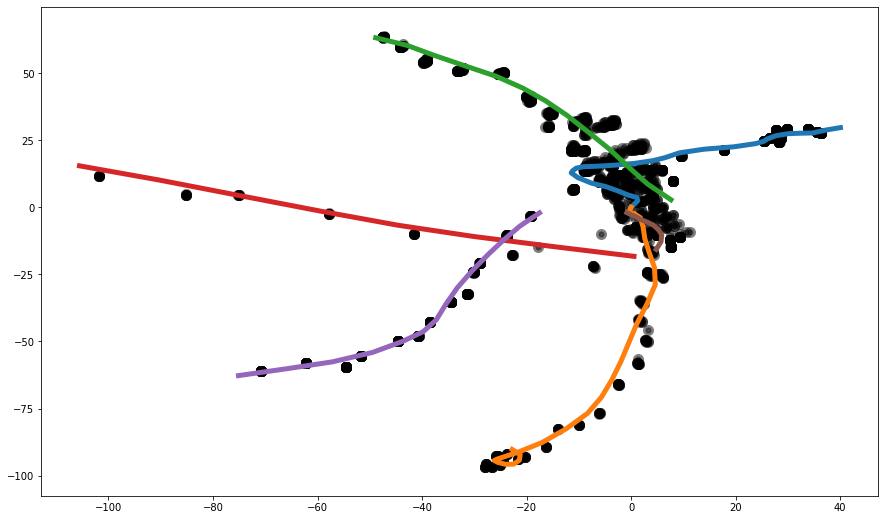

In [1462]:
for trajectory in trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 2], alpha = 1, linewidth = 5)
    

for i, trajectory in enumerate(predictions):
    plt.scatter(trajectory[:, 0], trajectory[:, 2], alpha = 0.5, linewidth = 5, color = 'black')
    
fig = plt.gcf()
fig.set_size_inches(15,9)

### OSPA METRIC

No python implementation exists so I use the 2D earth mover's distance instead

In [1323]:
frames_X = []
for i in range(LENGTH):
    frames_X.append(trajectories[:, i, :])

In [1324]:
frames_Y = []
for j in range(LENGTH):
    frames_Y.append(predictions[:, j, :])

In [1325]:
for i in range(LENGTH):
    X = frames_X[i][~numpy.isnan(frames_X[0]).any(axis=1)][:, ::2]
    Y = frames_Y[i][~numpy.isnan(frames_Y[0]).any(axis=1)][:, ::2]
    d = cdist(Y, X)**2
    assignment = linear_sum_assignment(d)
    ospa = (d[assignment]).sum()
    print(ospa)

0.03392020189101917
0.05284845343079394
11.01771753886179
0.021108594214691162
0.06491172274712438
0.00812277993275216
0.022686380339120984
0.008591266712002107
67.93133100871631
82.20387400786589
90.79949559858517
121.99152532848677
197.2225635944505
346.3844916969404
613.0717121083229
1038.762016380287
0.0794094792909545
0.0076733289323040015
0.09150950238902938
0.009248433416256722
0.016189069142306025
0.03203915776483063
0.013155860888605271
0.01440270464366428
0.08041199976179805
0.014700758865256236
0.00790927582195652
0.005222499316212902
0.010871485472233768
0.0179141858686216
